In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cluster_model import ClusterModel
from datetime import timedelta
import pickle
import seaborn as sns

In [2]:
with open('../data/station_data/2024 model/v2/tph_4/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

In [3]:
cluster_model = ClusterModel(station_data=station_data, in_transit=[], tph=4)
horizontal_squares, vertical_squares, clusters = cluster_model.cluster_stations(0.004)
cluster_model.init_clusters()
cluster_model.init_state(path='../data/station_data/status_at_time/2024_6_20_2:19.csv', time=timedelta(hours=2))
# cluster_model.init_by_3()


# cluster_model.show_bikes()

# num_stations = [len(cluster) for cluster in clusters]
# sns.heatmap(np.array(num_stations).reshape((vertical_squares, horizontal_squares)))

45 horizontal squares and 64 vertical squares. Total squares: 2880


2:15:00
65 in transit
73 failures
25 critical failures
0 total trips
-------------------
2:30:00
68 in transit
134 failures
49 critical failures
57 total trips
-------------------
2:45:00
63 in transit
175 failures
63 critical failures
114 total trips
-------------------
3:00:00
69 in transit
221 failures
69 critical failures
168 total trips
-------------------
3:15:00
66 in transit
245 failures
73 critical failures
223 total trips
-------------------
3:30:00
69 in transit
280 failures
79 critical failures
276 total trips
-------------------
3:45:00
65 in transit
309 failures
82 critical failures
330 total trips
-------------------
4:00:00
56 in transit
329 failures
83 critical failures
388 total trips
-------------------
4:15:00
71 in transit
355 failures
89 critical failures
433 total trips
-------------------
4:30:00
73 in transit
384 failures
90 critical failures
487 total trips
-------------------
4:45:00
99 in transit
417 failures
96 critical failures
546 total trips
------------

0

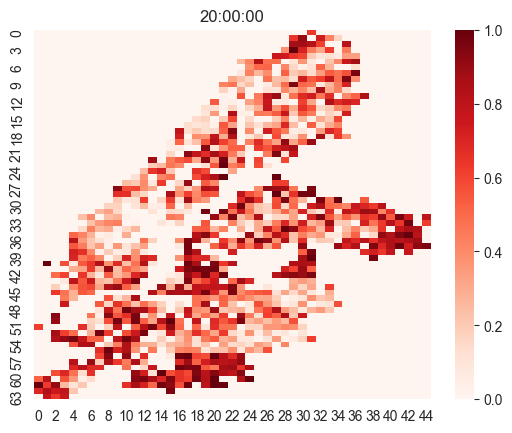

In [4]:
end_time = cluster_model.curr_time + timedelta(hours=18)
image_number = 0
while cluster_model.curr_time < end_time:
    cluster_model.sim()
    # cluster_model.sim_by_3()
    print(cluster_model.curr_time)
    print(len(cluster_model.in_transit), 'in transit')
    print(cluster_model.failures, 'failures')
    print(cluster_model.critical_failures, 'critical failures')
    print(cluster_model.total_trips, 'total trips')
    print('-------------------')
    if image_number < 10:
        t = f'000{image_number}'
    elif image_number < 100:
        t = f'00{image_number}'
    elif image_number < 1000:
        t = f'0{image_number}'
    else:
        t = f'{image_number}'
    cluster_model.show_bikes(save=True, name=f'{t}')
    cluster_model.show_fill_percent(save=True, name=f'{t}')
    image_number += 1
    
os.system('magick images/bikes/*.png gifs/bikesv2.gif')
os.system('magick images/fill/*.png gifs/fillv2.gif')


In [28]:
cluster_model.sim()
print(cluster_model.curr_time)
print(len(cluster_model.in_transit))
print(cluster_model.failures)
print(cluster_model.critical_failures)

13:45:00
1435
986
37
